In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features

plt.style.use("ggplot")

# Convert annotation to raster

Notebook illustrating how to convert vector annotation stored in a SeaBee geopackage to an integer raster with the same properties (shape, cell size, bounds etc.) as the original image mosaic.

In [2]:
def annotation_to_raster(gpkg_path, snap_raster_path, level, anno_raster_path):
    """Convert annotation from a SeaBee annotation geopackage to a raster.

    Args
        gpkg_path:        Str. Path to geopackage containing annotation.
        sanp_raster_path: Str. Path to original image mosaic (used as the
                          "snap raster")
        level:            Int. Either 1, 2 or 3. Level in the annotation
                          hierarchy to convert
        anno_raster_path: Str. GeoTiff to be created.

    Returns
        Geodataframe. A new raster is created. Vector annotations for the
        level of interest are returned.
    """
    assert level in (1, 2, 3), "'level' must be 1, 2 or 3."
    assert (
        anno_raster_path[-4:] == ".tif"
    ), "'anno_raster_path' should be a '.tif' file."

    # Open the "snap raster" and get output properties
    dtype_dict = {1: "uint8", 2: "uint16", 3: "uint32"}
    with rasterio.open(snap_raster_path) as src:
        meta = src.meta.copy()
        meta.update(
            compress="lzw", count=1, nodata=0, dtype=dtype_dict[level], driver="GTiff"
        )
        crs = meta["crs"]

    # Reproject annotation to same CRS and get data for the 'level' of interest
    gdf = gpd.read_file(gpkg_path, layer="annotation")
    gdf = gdf.to_crs(crs)
    gdf.dropna(subset=f"lev{level}_name", inplace=True)
    gdf[f"lev{level}_code"] = gdf[f"lev{level}_code"].astype(int)

    # Rasterize
    with rasterio.open(anno_raster_path, "w+", **meta) as dst:
        out_arr = dst.read(1)
        shapes = (
            (geom, value) for geom, value in zip(gdf.geometry, gdf[f"lev{level}_code"])
        )
        burned = features.rasterize(
            shapes=shapes, fill=0, out=out_arr, transform=dst.transform
        )
        dst.write_band(1, burned)

    return gdf

In [3]:
# User input
gpkg_path = r"/home/notebook/shared-seabee-ns9879k/niva/2022/2022-08-31_RUNDE/Annotation/vector/2022-08-31_Remoy_Annotation.gpkg"
snap_raster_path = r"/home/notebook/shared-seabee-ns9879k/niva/2022/2022-08-31_RUNDE/2022-08-31_Remoy/1_drone/2_SpectroFly/0730_RGB_120m/Mosaics/20220831_0730_RGB_120m_transparent_mosaic_group1.tif"
level = 2
anno_raster_path = f"anno_rasterised_lev{level}.tif"

<AxesSubplot: >

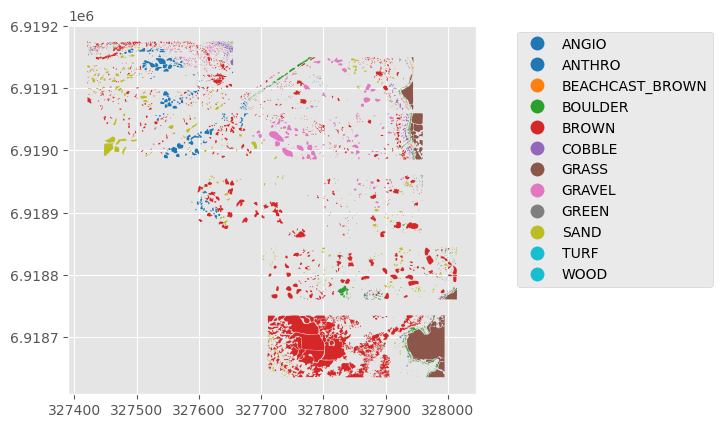

In [4]:
# Convert annotation
gdf = annotation_to_raster(gpkg_path, snap_raster_path, level, anno_raster_path)
gdf.plot(
    column=f"lev{level}_name", legend=True, legend_kwds={"bbox_to_anchor": (1.6, 1)}
)